In [37]:
# Gain modulation RNN with oja learning on weight matrix, nonlinear lqr
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from rnn_basic import RNN
import json
from torch.autograd.functional import jacobian
from torch import tensor
import torch
import torch.nn as nn
import scipy.linalg as sp_linalg
from tqdm.notebook import tqdm

## Loading Trained Weights

In [38]:
with open('../weights/SIN_bpgain_128_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [39]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses'])

In [40]:
gain = np.array(weight_history['trained gain'])
shift = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

## Defining Network

In [41]:
time_constant = 100 #ms
timestep = 10 #ms
num_nodes = 128
init_activation = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activation, gain, shift, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

In [42]:
# define inputs and targets
ndata = 600
time = ndata * timestep
time_points = np.arange(ndata).reshape(-1, 1)
inputs = np.sin(time_points/60*np.pi)
inputs = inputs.reshape(-1, 1)
dt = network.timestep/network.time_const
T = np.arange(0, ndata)

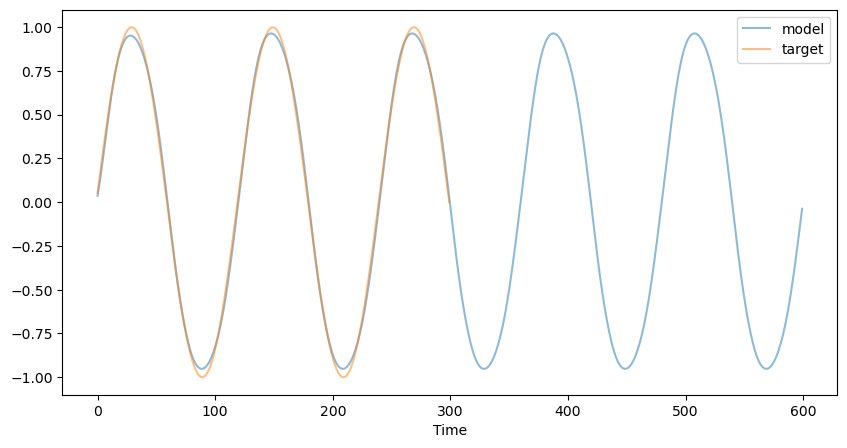

In [43]:
outputs, activations = network.simulate(time, torch.tensor(inputs).float())
targets = np.sin((time_points+1)/60*np.pi)[0:300]
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(np.arange(len(targets)), targets, alpha=0.5, label='target')
plt.xlabel('Time')
plt.legend()

## Manual Simulatation

In [44]:
# System Description
def f_tensor(x_tensor, u_tensor):
    gains_tensor = tensor(gain)
    weights_tensor = tensor(weight_matrix)
    shifts_tensor = tensor(shift)
    activation_func = nn.Sigmoid()
    y_tensor = (1 - dt) * x_tensor + dt * activation_func(gains_tensor * (torch.matmul(weights_tensor, x_tensor) + u_tensor - shifts_tensor))
    return y_tensor

def f(x, u):
    x_tensor = tensor(x)
    u_tensor = tensor(u)
    y_tensor = f_tensor(x_tensor, u_tensor)
    y = y_tensor.numpy()
    return y

def jacob(x, u):
    x_tensor = tensor(x)
    u_tensor = tensor(u)
    dydx, dydu = jacobian(f_tensor,(x_tensor, u_tensor))
    # print(dydx)
    Jx_tensor = dydx.squeeze(dim=(1,3))
    Ju_tensor = dydu.squeeze(dim=(1,3))
    Jx = Jx_tensor.numpy()
    Ju = Ju_tensor.numpy()
    return Jx, Ju

In [45]:
# for testing jacobian
# # System Description
# def f_tensor(x_tensor, u_tensor):
#     gains_tensor = tensor(gains)
#     weights_tensor = tensor(weight_matrix)
#     shifts_tensor = tensor(shifts)
#     activation_func = nn.Sigmoid()
#     # print(weights_tensor[:,0])
#     y0_tensor = (1 - dt) * x_tensor[0:2,:] + dt * activation_func(gains_tensor[0:2,:] * x_tensor[0:2,:] + u_tensor[0:2,:] - shifts_tensor[0:2,:])
#     return y0_tensor

# def f(x, u):
#     x_tensor = tensor(x)
#     u_tensor = tensor(u)
#     y_tensor = f_tensor(x_tensor, u_tensor)
#     y = y_tensor.numpy()
#     return y

# def jacob(x, u):
#     x_tensor = tensor(x)
#     u_tensor = tensor(u)
#     dydx, dydu = jacobian(f_tensor,(x_tensor, u_tensor))
#     print(dydx)
#     J_tensor = dydx.squeeze(dim=(1,3))
#     J = J_tensor.numpy()
#     return J

In [46]:
# define matrices
c = np.eye(num_nodes)
Bnoise = np.eye(num_nodes)
W = np.eye(num_nodes) * 0.005
V = np.eye(num_nodes) * 0.005
Q = np.eye(num_nodes) * 1
R = np.eye(num_nodes) * 0.01

# define noise
x_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=W, size=len(T))).T
y_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=V, size=len(T))).T
x_noises[:,0:50] = 0
x_noises[:,50:60] += 0.1
x_noises[:,60:150] = 0
x_noises[:,150:160] += 0.1
x_noises[:,160:] = 0

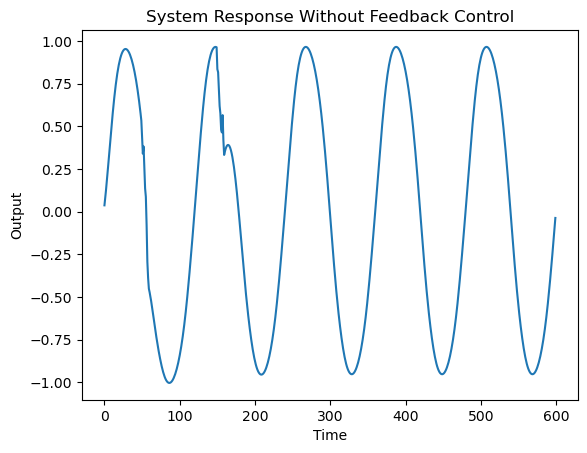

In [47]:
# Simulation Without Control
x = init_activation.copy()
u = init_activation.copy()
xs = []
ys = []
outputs_o = []

for i in T:
    
    # update x
    this_input = inputs[i] * input_weight_matrix.T
    u = this_input.copy()
    process_noise = x_noises[:,i].reshape(-1,1)
    x1 = f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # output
    y = c @ x
    output = output_weight_matrix @ x
    
    # save
    xs.append(x)
    ys.append(y)
    outputs_o.append(output.item())

# Plot the output
plt.plot(T, outputs_o)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

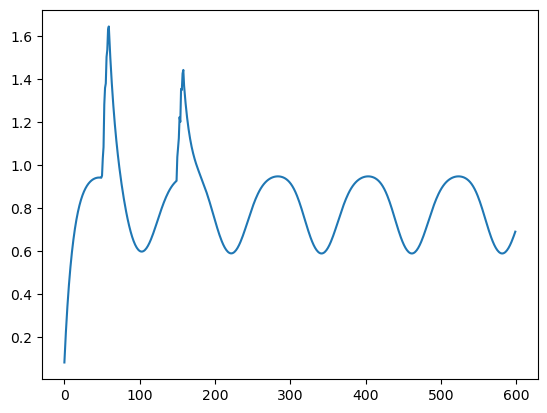

In [48]:
x1s = [x[0].item() for x in xs]
plt.plot(T, x1s)
plt.show()

### Non-linear LQR

In [49]:
ideal_activations = activations.detach().numpy()
x = init_activation.copy()
u = init_activation.copy()
xs = []
outputs_b = []

for i in tqdm(T):

    # Update x
    this_input = inputs[i] * input_weight_matrix.T
    u = u + this_input.copy()
    process_noise = x_noises[:,i].reshape(-1,1)
    x1 = f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # Output
    output = output_weight_matrix @ x

    # Save
    xs.append(x)
    outputs_b.append(output.item())

    # LQR
    this_ideal_activation = ideal_activations[i,:].reshape(-1,1)
    A, B = jacob(x, u)
    X = sp_linalg.solve_discrete_are(A, B, Q, R)
    K = np.dot(np.linalg.pinv(R + np.dot(B.T, np.dot(X, B))), np.dot(B.T, np.dot(X, A)))
    u = -K @ (x - this_ideal_activation)
    # print(np.mean(u))

  0%|          | 0/600 [00:00<?, ?it/s]

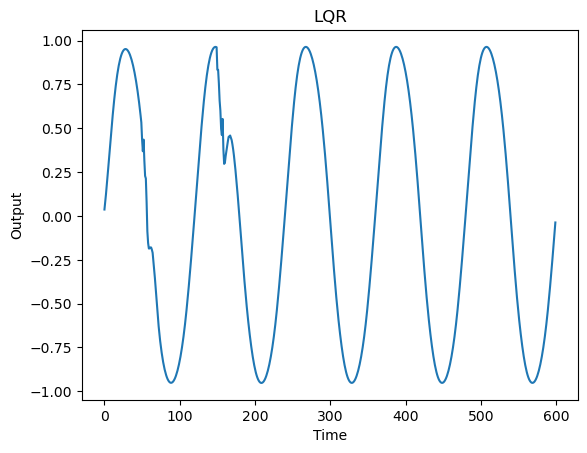

In [50]:

# Plot the state
# outputhats = [(output_weight_matrix @ x).item() for x in xhats]
plt.plot(T, outputs_b)
# plt.plot(T, outputs_o)
# plt.plot(T, outputhats)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('LQR')
plt.show()

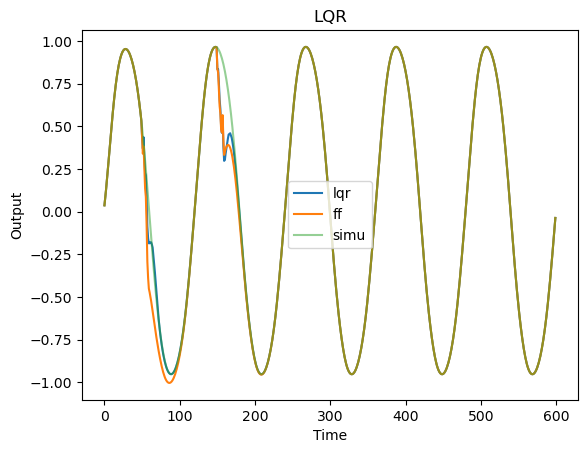

In [51]:
plt.plot(T, outputs_b, label='lqr')
plt.plot(T, outputs_o, label='ff')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='simu')
# plt.plot(T, outputhats)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('LQR')
plt.legend()
plt.show()